# Exploring Sweden’s Job Market Geography: A Look at Arbetsförmedlingen Data

**Intended Readership**: General public and fellow data enthusiasts interested in Swedish labor market insights.

---

## 1. Introduction

**Where are the jobs in Sweden, really?** Working with publicly available data from Arbetsförmedlingen (Sweden’s Public Employment Service), we can map out where employers are hiring, how many vacancies they are offering, and in which fields. By combining these job listings with **population statistics** and **municipality boundaries**, we can explore:

- Which municipalities (kommuner) have the most job listings in raw terms?
- Are there smaller municipalities where job density (jobs per capita) is unexpectedly high?
- Which **occupation fields** (e.g., Data/IT, Hälso- och sjukvård, Administration, etc.) are prominent in specific areas?
- Finally we'll look at the specifically the distribution of Data/IT over Sweden's regions.

The goal of this post is twofold:
1. **Illustrate** how to collect, clean, and merge these datasets.
2. **Visualize** the distribution of jobs across Swedish municipalities, highlighting interesting patterns that might guide job seekers, policymakers, or anyone curious about Sweden’s labor market landscape.

---

## 2. Data


This project relies on **three main data sources**:

1. **Arbetsförmedlingen Job Listings**  
   - Retrieved from the open API: `https://jobstream.api.jobtechdev.se/snapshot`.  
   - Contains ~39,000 job listings, stored in `job_listings.json`, with key fields:  
     - `workplace_address.municipality` — job location.  
     - `occupation_field.label` — occupational category (e.g., “Data/IT”).  
     - `number_of_vacancies` — open positions per listing.

2. **Municipality Population**  
   - Scraped from a Wikipedia table of Swedish municipalities, including population and region (län).  
   - Saved in `swedish_municipalities_population.csv`.

3. **Geographic Boundaries (GeoJSON)**  
   - Files `swedish_municipalities.geojson` and `swedish_regions.geojson` sourced from [Open Knowledge Foundation Sweden](https://github.com/okfse).  
   - Enables **choropleth** maps to visualize data at municipal and regional levels.


---

## 3. Data Collection & Wrangling
We bring together data from diverse sources, preparing it for analysis. The process includes retrieving job listings, municipal population figures, and geographic boundaries, followed by cleaning and formatting the data to ensure compatibility and accuracy for our visualizations.

### 3.1 Job Listings
We fetch job listing data from Arbetsförmedlingen's API, including job location, categories, and vacancies, and save it locally for reproducibility. Missing values in `number_of_vacancies` are replaced with `1`, ensuring consistency by treating unspecified vacancies as at least one position. The cleaned dataset is then ready for further integration.

In [1]:
import requests
import json
import pandas as pd

def fetch_and_process_job_listings():
    """
    Fetch job listings from an API, save to a file, and return as a DataFrame.
    """
    url = "https://jobstream.api.jobtechdev.se/snapshot"

    # Use API
    response = requests.get(url)

    # Get JSON
    job_listings = response.json()

    # Save to a file for reproducibility
    with open("job_listings.json", "w") as file:
        json.dump(job_listings, file)

    # JSON to a DataFrame
    job_listings_df = pd.DataFrame(job_listings)

    # Replace NaN values in 'number_of_vacancies' with 1
    job_listings_df['number_of_vacancies'] = job_listings_df['number_of_vacancies'].fillna(1)

    return job_listings_df

# Getting the job listing DataFrame
job_listings_df = fetch_and_process_job_listings()

### 3.2 Population Data

In this step, we scrape a list of Swedish municipalities, their counties (län), and populations from a Wikipedia page. This data is essential for understanding job density and creating meaningful visualizations. 

The scraping process involves extracting data from an HTML table on the Wikipedia page. Specifically, we retrieve:

- **Municipality names** (e.g., "Stockholm")
- **Region (län) names** (e.g., "Stockholms län")
- **Population figures** for each municipality

To ensure the scraped data aligns with the job listing dataset, we perform several cleaning steps:
1. **Removing "kommun" suffix**: All municipality names include "kommun" (e.g., "Stockholms kommun"), which is stripped to match the job listing format.
2. **Handling trailing 's' for non-vowel endings**: Municipality names ending with 's' after a non-vowel (e.g., "Danderyds") are cleaned by removing the 's' to align formats. However, exceptions are made for names ending with "ors" (e.g., "Degerfors" remains unchanged).
3. **Manual corrections**: Some municipalities, such as "Falun" and "Grums," require manual fixes due to quirks in the cleaning logic.

The cleaned data is saved to a CSV file, `swedish_municipalities_population.csv`, for reproducibility and further use. This ensures that population statistics aligns with job listing data, enabling later analysis and visualization.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

def scrape_swedish_municipalities():
    """
    NOTE: BOTH Saves data to a CSV and returns it as a DataFrame.    
    
    Scrapes Swedish municipalities, the regions they belong to, and their populations
    from a Wikipedia page.

    - Fetches and parses HTML content of the Wikipedia page.
    - Extracts municipality names, region (län) names, and population data from the relevant table.
    - Cleans the data and saves it to 'swedish_municipalities_population.csv'.

    Returns:
        pandas.DataFrame: A DataFrame with columns 'Municipality', 'Region', and 'Population'.
    """
    
    # URL of the Wikipedia page
    url = "https://sv.wikipedia.org/wiki/Lista_%C3%B6ver_Sveriges_kommuner"
    
    # Send a GET request to the webpage
    response = requests.get(url)
    
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the table containing the municipalities and population data
    table = soup.find('table', {'class': 'wikitable'})
    
    # Extract table rows
    rows = table.find_all('tr')
    
    # Prepare lists to store the extracted data
    municipalities = []
    regions = []
    populations = []
    
    # Iterate through rows to extract data (skipping the header row)
    for row in rows[1:]:
        cols = row.find_all('td')

        #   cols[1] -> Municipality
        #   cols[3] -> Region
        #   cols[4] -> Population
        if len(cols) > 4:
            # Municipality name
            municipality = cols[1].get_text(strip=True)
            
            # Remove " kommun" suffix if present
            if municipality.endswith(" kommun"):
                municipality = municipality.replace(" kommun", "") 

            # Check if the municipality ends with a non-vowel, whitespace, and 's'
            if re.match(r".*[^aeiouyåäö]s$", municipality) and not municipality.endswith("ors"):
                municipality = re.sub(r"s$", "", municipality)
          
            # Region (län)
            region = cols[3].get_text(strip=True)
            
            # Remove " kommun" suffix if present
            if region.endswith(" län"):
                region = region.replace(" län", "")   

            # Remove hidden <span style="display:none"> from the population cell
            for hidden_span in cols[4].find_all('span', style='display:none'):
                hidden_span.decompose()
            
            # Now get only the visible text in that cell
            population_raw = cols[4].get_text(strip=True)

            # Remove non-breaking spaces and regular spaces
            population_raw = population_raw.replace('\xa0', '').replace(' ', '')

            # Append data
            municipalities.append(municipality)
            regions.append(region)
            populations.append(population_raw)
    
    # Update specific entries for exceptions
    municipalities = ["Falun" if name == "Falu" else "Grums" if name == "Grum" else name for name in municipalities]

    # Create a DataFrame to store the results
    data = pd.DataFrame({
        'Municipality': municipalities,
        'Region': regions,
        'Population': populations
    })
    
    # Convert population from string to int
    data["Population"] = data["Population"].astype(int)
    
    # Save to CSV
    data.to_csv('swedish_municipalities_population.csv', index=False, encoding='utf-8')
    
    return data

population_df = scrape_swedish_municipalities()

### 3.3 Aggregating Vacancies and Merging with Population Data

In this step, we calculate the total number of vacancies for each municipality by aggregating the job listing data. Since a single job listing can advertise multiple positions, we sum up the `number_of_vacancies` for all listings within each municipality. 

Once we have the total vacancies by municipality, we merge this data with the population dataset. This alignment allows us to calculate job density for each municipality by dividing the total number of vacancies by the population and scaling it to jobs per 1,000 people. This metric, `Jobs_per_1000`, helps identify areas with particularly high or low job availability relative to their population. 


In [3]:
# Number of vacancies is added together by the municpality
df_jobs_by_muni = (
    job_listings_df
    .groupby(job_listings_df["workplace_address"].apply(lambda x: x.get("municipality") if pd.notnull(x) else None)) 
    .agg({"number_of_vacancies": "sum"})
    .reset_index()
    .rename(columns={"workplace_address": "Municipality"})
)

# Merge with population data
merged_df = pd.merge(df_jobs_by_muni, population_df, on="Municipality", how="left")

# Create a new column with job density
merged_df["Jobs_per_1000"] = 1000 * merged_df["number_of_vacancies"] / merged_df["Population"]

## 4. Visual Analysis

We analyze the data using various visualizations:

- **Bar Diagrams**: Compare total job vacancies across municipalities relative to their population.
- **Choropleth Map of Job Density**: Visualize overall job density (jobs per 1,000 residents) across municipalities.
- **Choropleth Subplots**: Focused maps showing job density in specific fields like Health Services, IT, and other prominent sectors.
- **Tree Map**: Visualize the distribution of jobs across occupation fields.
- **Regional IT Map**: Display the geographic distribution of Data/IT vacancies by region.


### 4.1 Choropleth of Total Jobs (Figure 1)

We create a bar chart to highlight the top 15 municipalities by total job vacancies and compare them to their populations. The chart overlays two bars for each municipality: one for total vacancies (blue) and one for population (orange). 

Stockholm is used as a baseline, where the population bar matches the job bar in length. For other municipalities, the difference between the bars shows whether they have a surplus of jobs (blue bar longer) or a surplus of population (orange bar longer). This provides a clear view of which municipalities are "winners" or "losers" in terms of job availability relative to their population.

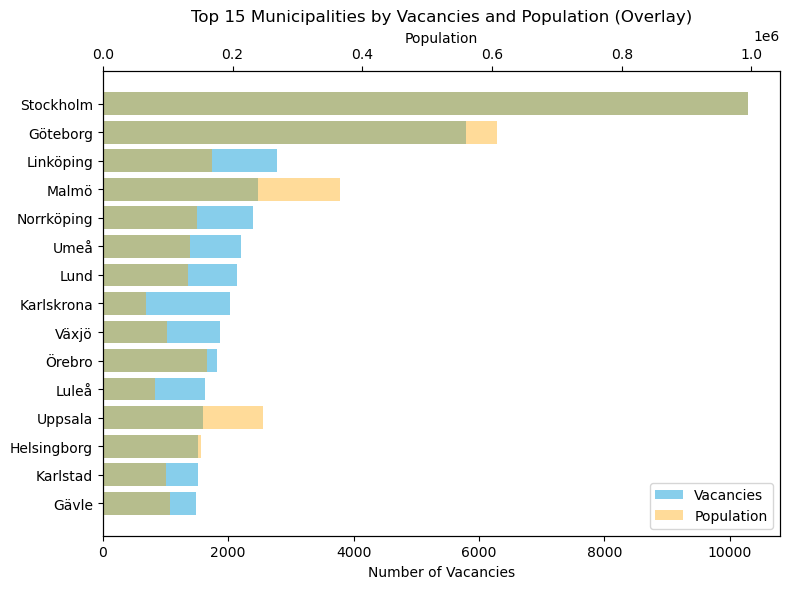

In [4]:
import matplotlib.pyplot as plt

# Identify top 15 municipalities by number_of_vacancies
top_15 = merged_df.nlargest(15, "number_of_vacancies")

fig, ax1 = plt.subplots(figsize=(8, 6))

# Create a twin x-axis sharing the same y-axis (municipalities)
ax2 = ax1.twiny()

# Plot vacancies on the first axis
vac_bars = ax1.barh(
    top_15["Municipality"], 
    top_15["number_of_vacancies"],
    color="skyblue", 
    label="Vacancies"
)

# Plot population on the second axis with some transparency
pop_bars = ax2.barh(
    top_15["Municipality"], 
    top_15["Population"], 
    color="orange", 
    alpha=0.4,        # <--- semi-transparent
    label="Population"
)

# Invert the y-axis so the largest bar is at the top
ax1.invert_yaxis()

# Label axes
ax1.set_xlabel("Number of Vacancies")
ax2.set_xlabel("Population")

# Title and layout
plt.title("Top 15 Municipalities by Vacancies and Population (Overlay)")

# A combined legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="lower right")

plt.tight_layout()
plt.show()

### Interpretation: Job Vacancies Across Municipalities

Using Stockholm as the baseline, we observe key trends in the job market distribution across Sweden's municipalities:

1. **Major Economic Hubs (Stockholm, Göteborg, Malmö)**:
   - While Stockholm leads in both population and total job vacancies, its **jobs per capita** ratio is lower than many smaller municipalities. 
   - Göteborg and Malmö also show a significant imbalance, with much larger populations compared to available jobs. This suggests greater competition for jobs or a mismatch between labor supply and demand.

2. **Smaller and Mid-Sized Municipalities**:
   - Municipalities like Växjö, Karlskrona, and Gävle have higher job vacancies relative to their populations, likely driven by specific industries or public-sector roles.
   - Uppsala, on the other hand, has a large population but fewer vacancies, which could indicate an oversaturated labor market or dominance of sectors like research and academia with fewer openings.

### Key Insight

The lower job vacancy rates per capita in Sweden's largest hubs challenge the assumption that these areas offer the most opportunities relative to their size. Several factors might explain this:
- **Regional competition**: Commuters from surrounding municipalities increase competition, lowering visible vacancies.
- **Economic factors**: The economies in these hubs may not be as robust as expected, offering fewer jobs per capita.
- **Data gaps**: Listings may not fully reflect all available positions.

This suggests smaller and mid-sized municipalities often offer better opportunities for job seekers per capita, contrary to expectations about major urban centers.


### 4.2 Choropleth of Job Density (Figure 2)

We create a choropleth map to visualize job density, measured as jobs per 1,000 residents, across Sweden's municipalities. Darker colors on the map indicate areas with higher job availability relative to their population. 

Using `GeoPandas` and `Matplotlib`, the code loads Sweden's municipal boundaries, merges them with job density data, and plots the map with a color gradient where intensity reflects job concentration. This visualization shows the relative distribution of job opportunities across the country.

Skipping field geo_point_2d: unsupported OGR type: 3


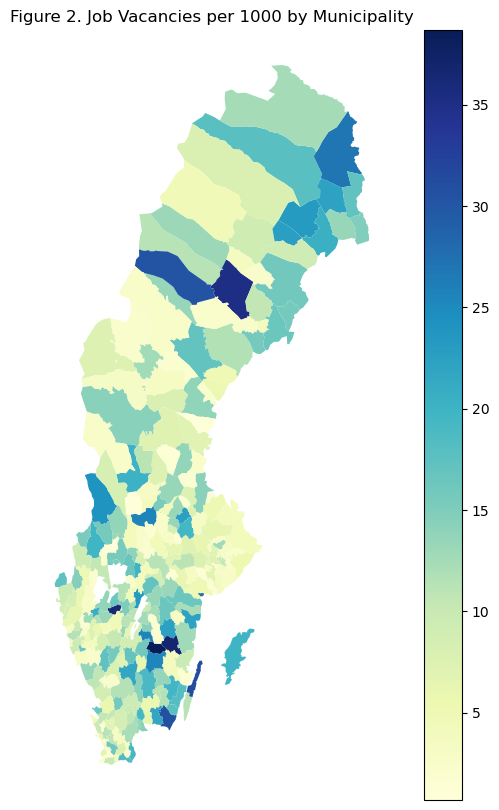

In [5]:
# Code Chunk 4
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Getting json to map
municipalities_geo = gpd.read_file("swedish_municipalities.geojson")

# Merge with the municipality-level data
geo_merged = pd.merge(municipalities_geo, merged_df, left_on="kom_namn", right_on="Municipality", how="left")

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_merged.plot(
    column="Jobs_per_1000",
    ax=ax,
    legend=True,
    cmap="YlGnBu",
    missing_kwds={"color": "black"}
)
plt.title("Figure 2. Job Vacancies per 1000 by Municipality")
plt.axis("off")
plt.show()

### Interpretation: Job Density Across Municipalities

The choropleth map "Job Vacancies per 1,000 by Municipality" reveals significant patterns in job density across Sweden:

1. **High Job Density in Smaller Municipalities**:  
   Certain smaller municipalities, especially in northern Sweden, stand out with high job density (over 30 jobs per 1,000 residents). These areas often rely on specialized industries or large employers relative to their smaller populations, leading to higher fluctuations in job availability per resident.

2. **Lower Density Around Urban Centers**:  
   While Stockholm Municipality itself appears moderate, the surrounding areas in the Stockholm region have notably low job density, a trend also visible, though less pronounced, around Göteborg and Malmö. This suggests that despite their high economic activity, the large populations dilute the density metric.

3. **Southern Sweden Trends**:  
   Southern Sweden overall shows higher job density compared to other parts, likely reflecting the concentration of industries and population hubs. 

### Key Insights:

- Rural areas, particularly in the north, may experience higher fluctuations in job density due to small population sizes, with industries like mining and forestry driving job creation. 
- The regions around Stockholm, Göteborg, and Malmö have lower job density despite being major economic hubs, highlighting how population size can affect job availability per capita.
- Southern Sweden exhibits relatively stable and higher job density compared to the north.
---



### 4.3 Which Industries Dominate? A Treemap of Occupation Fields (Figure 3)

The code uses `squarify` and `matplotlib` to create a **treemap** visualizing job vacancies across Sweden’s occupation fields. Each section represents a field, with its area reflecting the total vacancies, while unspecified fields are labeled "Unknown." 

This visualization helps identify which industries dominate the dataset, offering insights into why certain patterns emerge geographically. Understanding the importance of specific sectors helps guide our analysis and interpretation of job market data.

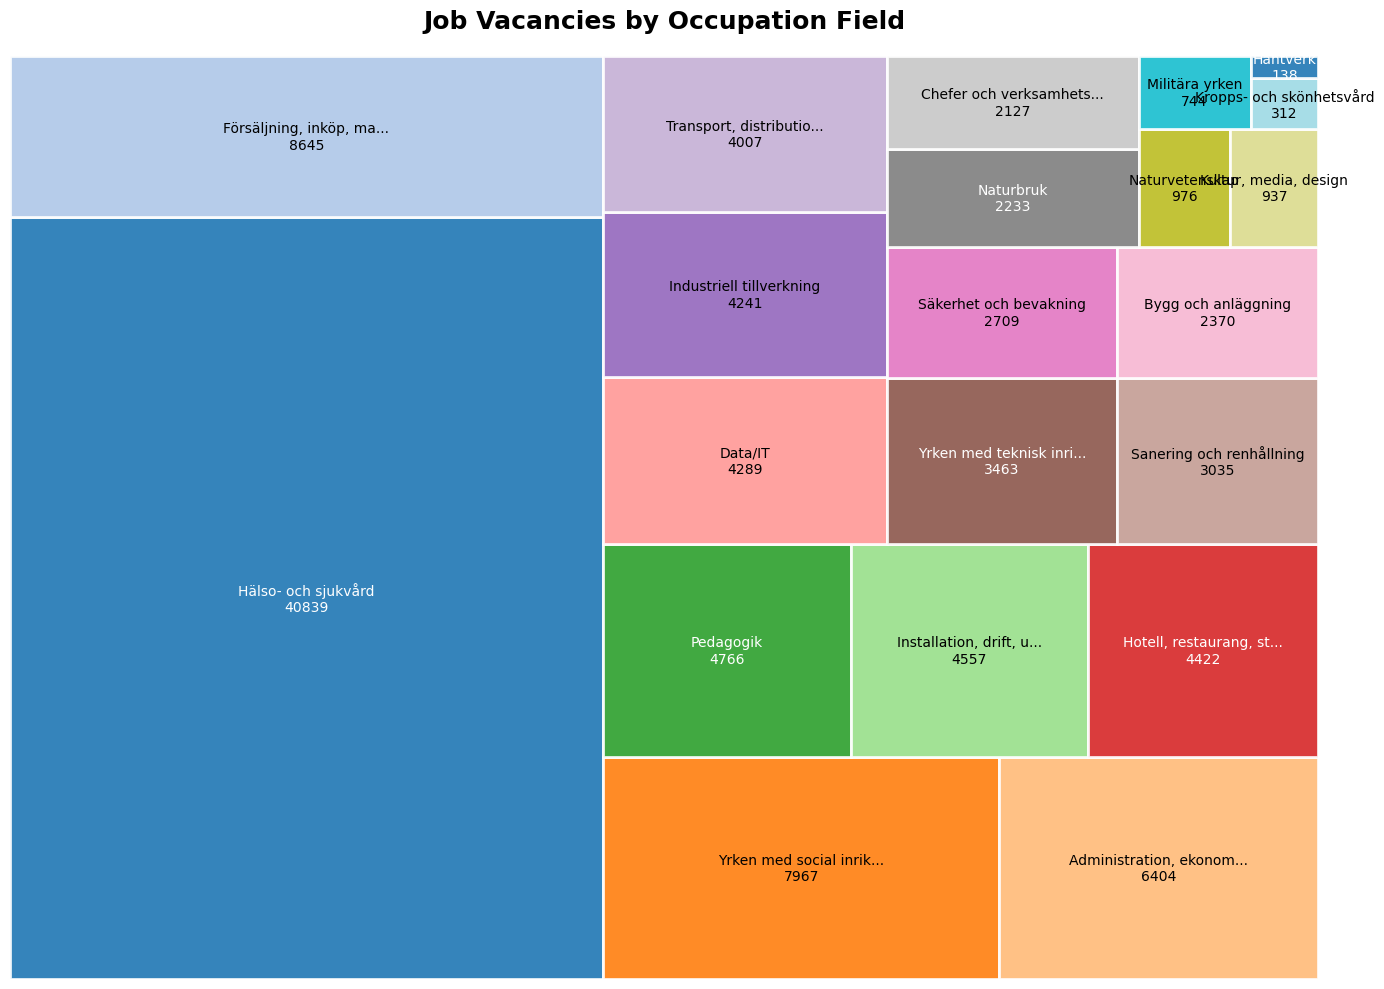

In [6]:
import squarify
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Data preparation
df_occ_field = (
    job_listings_df
    .groupby(job_listings_df["occupation_field"].apply(lambda x: x.get("label") if pd.notnull(x) else "Unknown"))
    .agg({"number_of_vacancies": "sum"})
    .reset_index() 
    .sort_values("number_of_vacancies", ascending=False)
)

# Prepare data for treemap
labels = df_occ_field["occupation_field"] + "\n" + df_occ_field["number_of_vacancies"].astype(str)
sizes = df_occ_field["number_of_vacancies"]

# Create the treemap
plt.figure(figsize=(14, 10))

# Normalize the values for consistent coloring
sizes = df_occ_field["number_of_vacancies"]
colors = plt.cm.tab20.colors  # Use a categorical color palette

# Define labels and truncate long text
labels = df_occ_field["occupation_field"].apply(lambda x: x if len(x) < 25 else x[:22] + "...") + \
         "\n" + df_occ_field["number_of_vacancies"].astype(int).astype(str) # int removes ".0"

# Adjust font color dynamically based on box color
def get_label_color(bg_color):
    r, g, b = mcolors.to_rgb(bg_color)
    return "black" if (r + g + b) / 3 > 0.5 else "white"

# Assign colors to the treemap boxes
color_assignments = [colors[i % len(colors)] for i in range(len(sizes))]

# Plot the treemap
squarify.plot(
    sizes=sizes,
    label=labels,
    color=color_assignments,
    alpha=0.9,
    edgecolor="white",
    linewidth=2
)

# Dynamically update label colors
ax = plt.gca()  # Get current axis
for text, bg_color in zip(ax.texts, color_assignments):
    label_color = get_label_color(bg_color)
    text.set_color(label_color)

# Title and layout adjustments
plt.title("Job Vacancies by Occupation Field", fontsize=18, fontweight="bold", pad=20)
plt.axis("off")  # Remove axes
plt.tight_layout()  # Optimize spacing
plt.show()

### Interpretation: Treemap of Job Vacancies by Occupation Field

The treemap highlights potential patterns in Sweden’s job market:

1. **Healthcare Dominance**: With 40,487 vacancies, healthcare is the largest sector. Its size could have a stabilizing effect on job density across Sweden, as healthcare demand might not vary drastically by region. However, the opposite could also be true: healthcare demand might be higher in municipalities with older populations and fewer younger workers, leading to greater concentrations of vacancies. Further investigation is needed to clarify these dynamics.

2. **Pedagogy and Consistent Sectors**: Fields like pedagogy might exhibit relatively stable demand across the country, potentially contributing to a more uniform distribution of job density in some areas.

3. **Urban Industries**: Sectors such as Sales, Administration, and Data/IT should dominate in urban centers like Stockholm, Gothenburg, and Malmö. Their prominence in cities may contribute to patterns in job density and the geographic distribution of vacancies.

4. **Region-Specific Fields**: Industries such as Manufacturing, Agriculture, and Military Careers appear more localized, often in low-population areas where a single large employer can create significant job density spikes.

### Insights for Further Analysis

Healthcare might stabilize density or drive local spikes depending on demographic factors like aging populations. Region-specific industries like Data/IT and manufacturing likely account for localized patterns. To explore these dynamics further, we propose focusing on:

- **Data/IT Jobs**: To understand region-specific demand.  
- **Service Jobs**: To analyze urban-rural trends, particularly in hospitality and retail, which may dominate in tourist-heavy or urban areas—or reveal unexpected patterns.  
- **Healthcare Jobs**: To investigate how aging populations and regional demographics influence demand and job density.  

### 4.4 Distribution of Jobs by Sector: Health, Service, and Data/IT

This section creates a subplot of three **choropleth maps** visualizing job density (jobs per 1,000 residents) for **Health**, **Service**, and **Data/IT** sectors across Sweden.

The code maps occupation fields to these broader categories, calculates job density by municipality, and normalizes it by population. Each map uses distinct color schemes to highlight job distribution, with municipalities showing high density labeled for clarity. 

Service includes jobs in sales, hospitality, cleaning, and security, often tied to local needs or driven by tourism. The maps show how these jobs are distributed across Sweden and reveal regional differences.

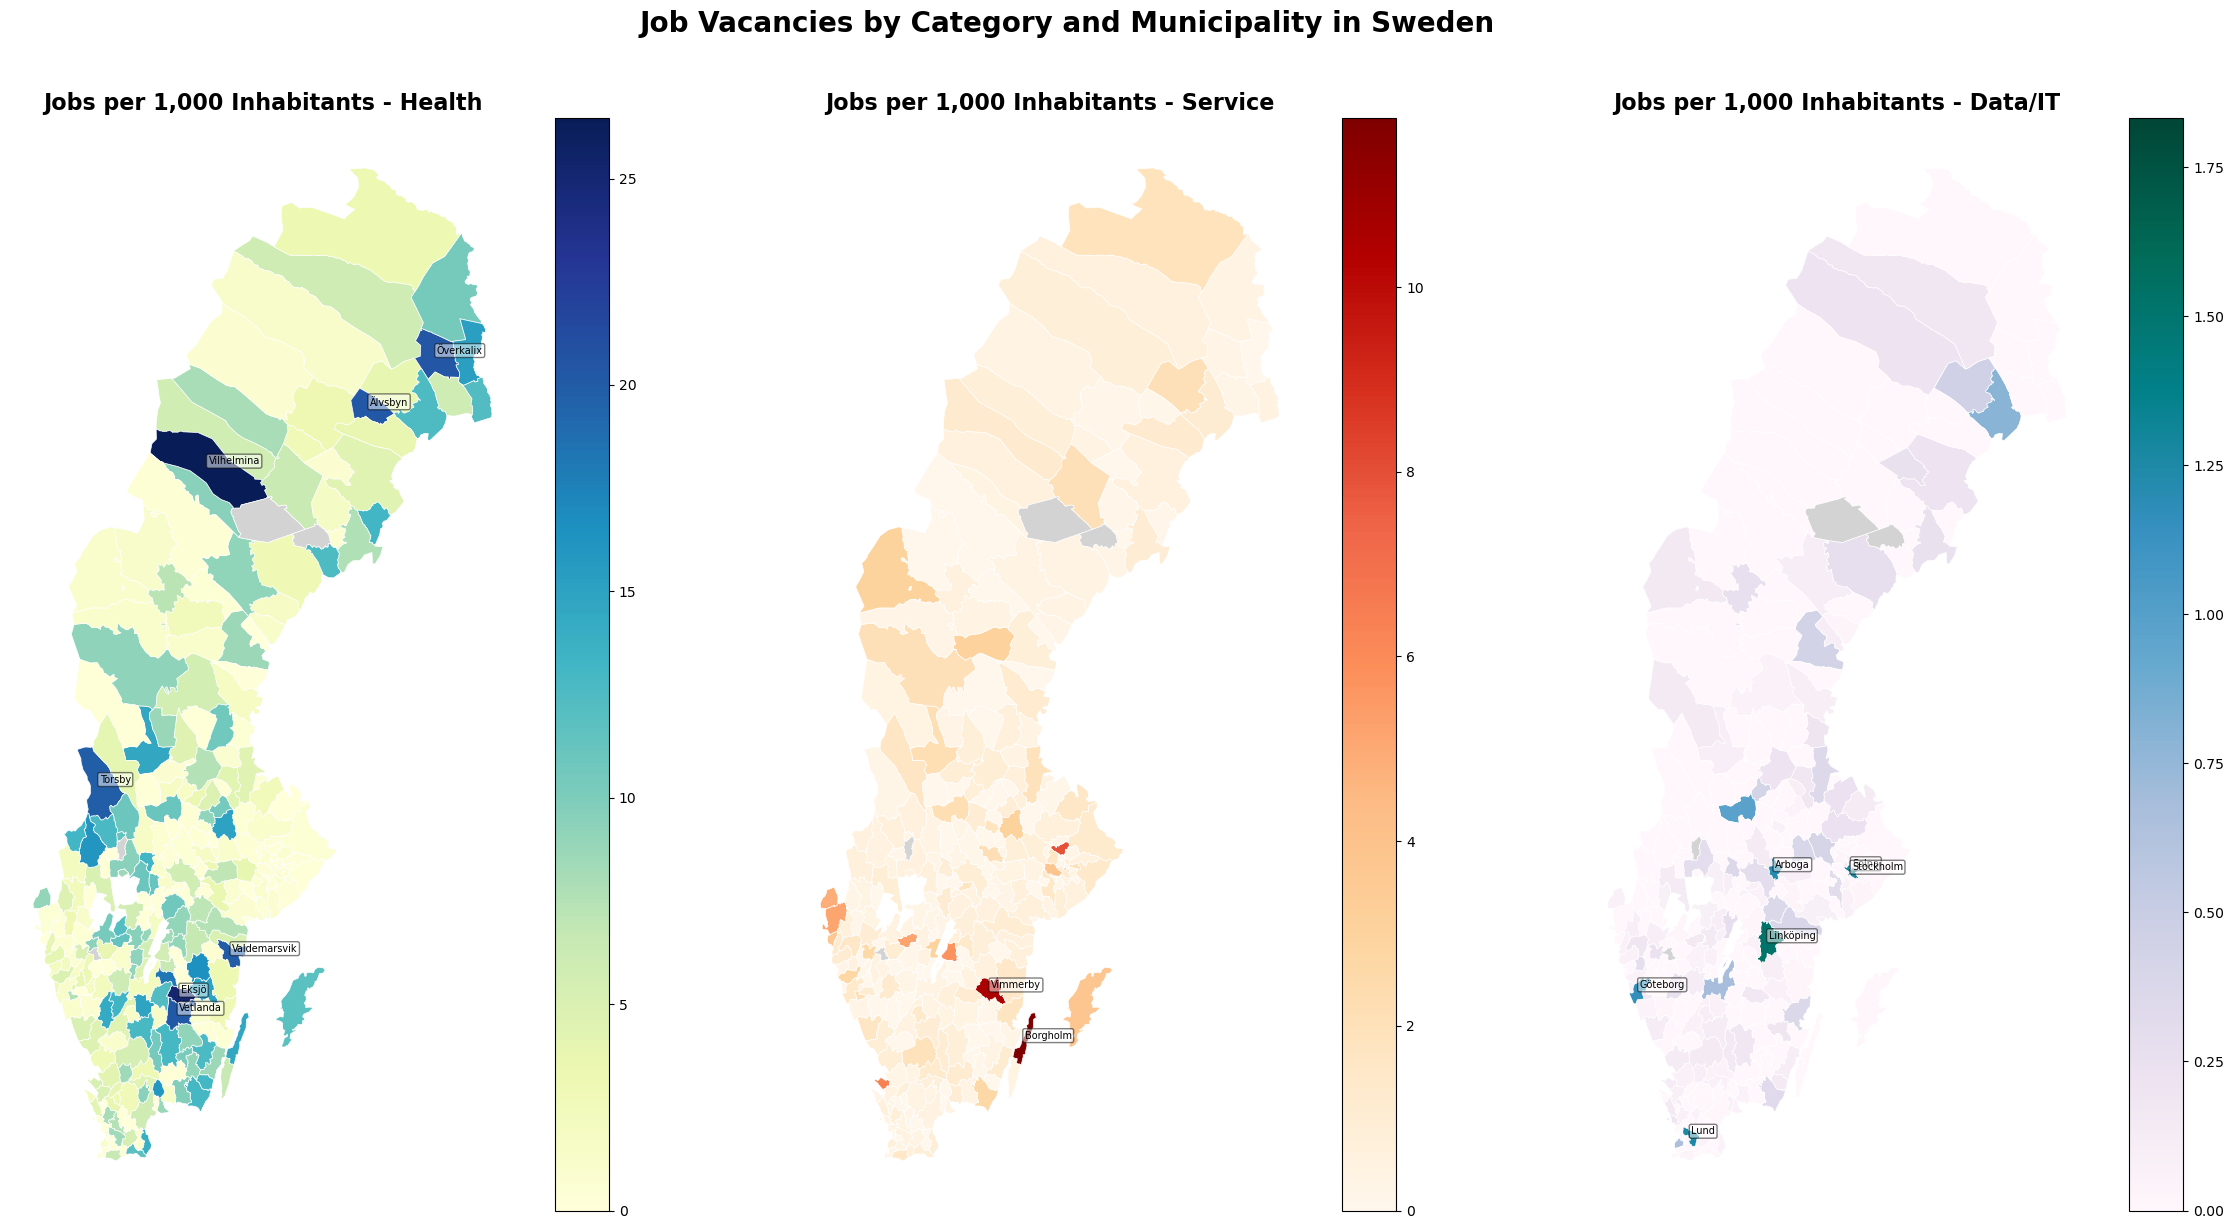

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Define the Category Mapping
# Mapping occupation fields to broader categories for analysis
category_mapping = {
    "Hälso- och sjukvård": "Health",
    "Hotell, restaurang, storhushåll": "Service",
    "Sanering och renhållning": "Service",
    "Kropps- och skönhetsvård": "Service",
    "Säkerhet och bevakning": "Service",
    "Data/IT": "Data/IT",
}

# Extract Municipality from 'workplace_address'
# Handles cases where the field may not be present or is missing
job_listings_df['Municipality'] = job_listings_df['workplace_address'].apply(
    lambda x: x.get('municipality') if isinstance(x, dict) else 'Unknown'
)

# Extract occupation labels from 'occupation_field'
# Adds a new column for the label of each job category
job_listings_df['occupation_label'] = job_listings_df['occupation_field'].apply(
    lambda x: x.get('label') if isinstance(x, dict) else 'Unknown'
)

# Map Occupation Labels to Categories
# Assigns each job listing to one of the defined categories
job_listings_df['category_mapped'] = job_listings_df['occupation_label'].map(category_mapping)

# Aggregate Vacancies by Municipality and Category
# Summarizes the number of vacancies in each municipality for each category
agg_jobs = (
    job_listings_df
    .groupby(['Municipality', 'category_mapped'])
    .agg({'number_of_vacancies': 'sum'})
    .reset_index()
)

# Pivot the data to have categories as separate columns
# This reshapes the data for easier comparison and plotting
pivot_jobs = agg_jobs.pivot(index='Municipality', columns='category_mapped', values='number_of_vacancies').fillna(0).reset_index()

# Merge the aggregated job data with population data
# Combines job vacancy data with population statistics for each municipality
job_population_df = pd.merge(
    pivot_jobs,
    population_df[['Municipality', 'Population']],
    on='Municipality',
    how='left'
)

# Calculate Jobs per 1,000 inhabitants for each category
# Normalizes the job data to make it comparable across municipalities
categories = ['Health', 'Service', 'Data/IT']
for category in categories:
    job_population_df[f'Jobs_per_1000_{category}'] = (job_population_df.get(category, 0) / job_population_df['Population']) * 1000

# Merge the geospatial data with job and population data
# Prepares the data for geographic visualization
geo_merged = pd.merge(
    municipalities_geo,
    job_population_df,
    left_on="kom_namn",
    right_on="Municipality",
    how="left"
)

# Define color maps and thresholds for the categories
# These settings control the appearance of the choropleth maps
cmap_dict = {
    'Health': 'YlGnBu',
    'Service': 'OrRd',
    'Data/IT': 'PuBuGn'
}

thresholds = {
    'Health': 19,
    'Service': 8,
    'Data/IT': 1
}

titles = {
    'Health': "Jobs per 1,000 Inhabitants - Health",
    'Service': "Jobs per 1,000 Inhabitants - Service",
    'Data/IT': "Jobs per 1,000 Inhabitants - Data/IT"
}

# Create the subplot for the three categories
fig, axes = plt.subplots(1, 3, figsize=(24, 12))

for ax, category in zip(axes, categories):
    # Column name for plotting job density
    column = f'Jobs_per_1000_{category}'

    # Plot the choropleth map for the category
    geo_merged.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap=cmap_dict[category],
        missing_kwds={"color": "lightgrey", "label": "No data"},
        edgecolor="white",
        linewidth=0.5
    )

    # Set the title for the subplot
    ax.set_title(titles[category], fontsize=16, fontweight='bold')
    ax.axis("off")
    
    # Label municipalities exceeding the threshold for each category
    threshold = thresholds[category]
    for idx, row in geo_merged.iterrows():
        if pd.notnull(row[column]) and row[column] > threshold:
            centroid = row.geometry.centroid
            ax.text(
                centroid.x,
                centroid.y,
                row['Municipality'],  
                fontsize=7, 
                ha='left',  
                va='bottom',  
                color='black',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.5)
            )

# Set the main title and layout
plt.suptitle("Job Vacancies by Category and Municipality in Sweden", 
             fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Interpretation: Job Vacancies by Sector (Health, Service, Data/IT)

Using thresholds of **19 for Health**, **8 for Service**, and **1 for Data/IT** for labeling, the maps show job density (jobs per 1,000 residents) across Swedish municipalities. 

#### **Health Jobs**  
Urban centers like Stockholm have lower health job density due to their large populations. However, rural areas like Vilhelmina and Överkalix show surprisingly high densities, likely due to fluctuations caused by smaller populations in the north. Overall, health jobs are more concentrated in southern and eastern Sweden, possibly reflecting older populations with greater healthcare needs. This concentration explains our earlier analysis of generally higher job density in southern sweden which now appears to be healthcare. 

#### **Service Jobs**  
High-density service jobs appear in municipalities like **Borgholm** and **Vimmerby**, driven by local demand and tourism. Urban centers like Stockholm and Gothenburg have lower density despite large job numbers, as population size dilutes the metric.

#### **Data/IT Jobs**  
Data/IT jobs are concentrated in urban hubs such as **Stockholm**, **Solna**, **Sundbyberg**, **Lund**, **Linköping**, and **Göteborg**, with densities up to 1.75 jobs per 1,000 residents. The low density in rural areas highlights the urban-centric nature of the tech sector. It is surprising that **Malmö** does not make the treshold, given its reputation as a major urban and economic hub.

### Connections to Earlier Data  
Healthcare jobs heavily influence rural job density, while service jobs add localized spikes in specific areas like tourist hubs. Data/IT jobs remain largely urban, tied to infrastructure and skilled labor. These patterns explain differences in job availability and density observed in earlier analyses. especially 

### 4.5 Data/IT Vacancies by Region

Data/IT jobs are a key focus, and this section analyzes their distribution at the regional level. Earlier analysis showed these jobs are concentrated in a few small municipalities, making a regional view more practical since commuting across regions is feasible.

The code filters for Data/IT jobs, cleans region names, and aggregates vacancies by region. It then merges this data with Sweden's regional boundaries to create a choropleth map showing total vacancies. Regions with more than 200 vacancies are labeled.

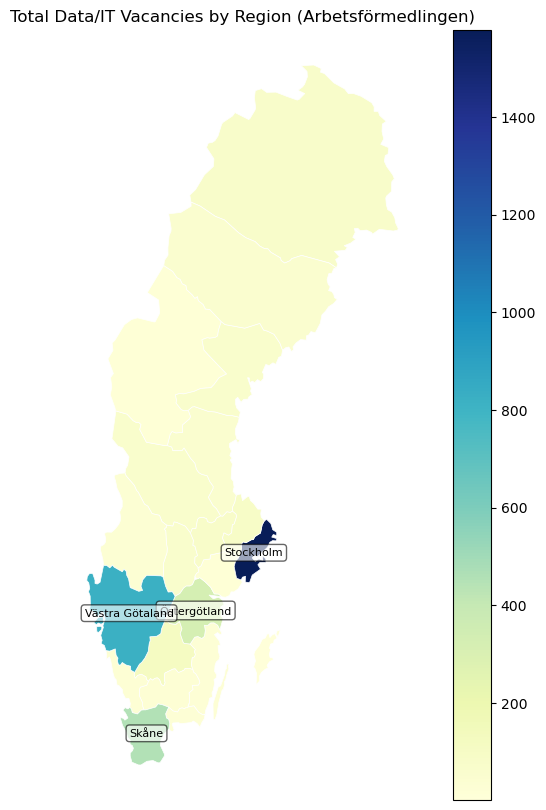

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Filter for Data/IT jobs:
df_data_it = job_listings_df[
    job_listings_df["occupation_field"]
    .apply(lambda x: x.get("label") if pd.notnull(x) else None) == "Data/IT"
].copy()

# Function to clean region names
def clean_region_name(region_string):
    """
    - Remove the literal ' län' at the end (if present).
    - Remove any trailing 's' from the resulting string.
    """
    if not isinstance(region_string, str):
        return None
    
    # 1. Remove " län"
    region_string = region_string.replace(" län", "")
    
    # 2. Remove trailing 's' if present
    if region_string.endswith("s"):
        region_string = region_string[:-1]
    
    return region_string

# Clean the region names in the Data/IT subset
df_data_it["cleaned_region"] = df_data_it["workplace_address"].apply(
    lambda addr: clean_region_name(addr["region"]) 
                 if isinstance(addr, dict) and "region" in addr else None
)

# Aggregate total Data/IT vacancies by cleaned_region
df_data_it_by_region = (
    df_data_it
    .groupby("cleaned_region")["number_of_vacancies"]
    .sum()
    .reset_index()
    .rename(columns={"cleaned_region": "Region", "number_of_vacancies": "DataIT_Vacancies"})
)

# Load your swedish_regions.geojson
regions_geo = gpd.read_file("swedish_regions.geojson")

# Merge the aggregated data with the GeoDataFrame
regions_merged = regions_geo.merge(
    df_data_it_by_region,
    left_on="name",    # e.g. "Stockholm", "Uppsala", "Skåne"
    right_on="Region", # 
    how="left"
)

# Fill missing Data/IT vacancies with 0
regions_merged["DataIT_Vacancies"] = regions_merged["DataIT_Vacancies"].fillna(0)

# Set a threshold for labeling
label_threshold = 200  # Adjust this threshold as needed

# Plot the choropleth: total Data/IT vacancies by region
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
regions_merged.plot(
    column="DataIT_Vacancies",
    ax=ax,
    legend=True,
    cmap="YlGnBu",
    edgecolor="white",
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

# Add labels for regions exceeding the threshold
for idx, row in regions_merged.iterrows():
    if row["DataIT_Vacancies"] > label_threshold:
        centroid = row.geometry.centroid
        ax.text(
            centroid.x,
            centroid.y,
            row["Region"],
            fontsize=8,
            ha="center",
            va="center",
            color="black",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.6)
        )

plt.title("Total Data/IT Vacancies by Region (Arbetsförmedlingen)")
plt.axis("off")
plt.show()


### Interpretation: Data/IT Vacancies by Region

Data/IT jobs are heavily concentrated in urban areas, with **Stockholm** leading as the dominant tech hub, exceeding 1,400 vacancies. **Västra Götaland** (including Gothenburg) and **Skåne** (including Malmö) also show strong activity, reinforcing their roles as secondary tech centers. 

In contrast, most other regions have minimal Data/IT opportunities, reflecting the sector's urban focus and reliance on access to tech companies, universities, and skilled labor. 

---

## 5. Observations & Discussion

### Potential Extensions

- Analyze other occupation fields to identify unique patterns or causes behind their distribution.  
- Incorporate alternative data sources like **LinkedIn** or **Indeed**, especially for tech-related jobs such as computer science. LinkedIn, for example, shows significantly more computer science roles compared to **Arbetsförmedlingen**, making it a valuable source for deeper insights if access is available.  

---

## 6. Conclusion

By integrating **Arbetsförmedlingen’s** open job listings with **population** and **municipality boundary** data, we gain a nuanced view of job opportunities across Sweden.

### Key Takeaways

- **Highly Populated Areas**: While municipalities in and around Stockholm dominate in total job vacancies, they do not exhibit much higher jobs per capita due to large populations which breaks expectations
- **Healthcare's Influence**: Healthcare drives a significant portion of job vacancies, particularly in southern Sweden and specific rural municipalities. Its demand shapes job density and affects overall job availability analysis.  
- **Tourism-Driven Jobs**: Some municipalities with tourism-oriented economies show higher service job densities, particularly in sectors like hospitality and retail.  
- **Data/IT Jobs**: Data/IT vacancies are concentrated in major economic hubs like Stockholm, Västra Götaland , and Skåne, aligning with expectations of their urban and innovation-centric nature


---

### References

- Arbetsförmedlingen (Public Employment Service) API: [JobTech Dev](https://jobtechdev.se/)  
- Wikipedia: [Lista över Sveriges kommuner](https://sv.wikipedia.org/wiki/Lista_%C3%B6ver_Sveriges_kommuner)  
- Municipality GeoJSON: *Publicly available or from your GitHub repository*  or [Open Knowledge Foundation Sweden](https://github.com/okfse).  

---